[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luket\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Raccolta dei post da Reddit in corso...
                                               title  \
0  Trump victory has sweeping climate change cons...   
1  Trump would be an "Extinction-Level Event" for...   
2  JD Vance says it’s ‘deranged’ for women not to...   
3  The Democrats Can’t Afford to Ignore Climate C...   
4  Ron DeSantis Makes “Climate Change Isn’t Real”...   

                                                text sentiment  emotion  
0  trump victory has sweeping climate change cons...   neutral  neutral  
1  trump would be an extinctionlevel event for th...   neutral  neutral  
2  jd vance says its deranged for women not to ha...  negative  neutral  
3  the democrats cant afford to ignore climate ch...   neutral  neutral  
4  ron desantis makes climate change isnt real of...  positive  neutral  
Visualizzazione del sentiment...


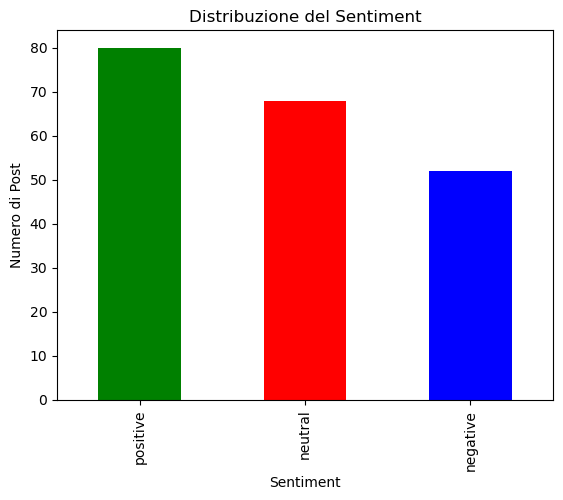

Visualizzazione delle emozioni...


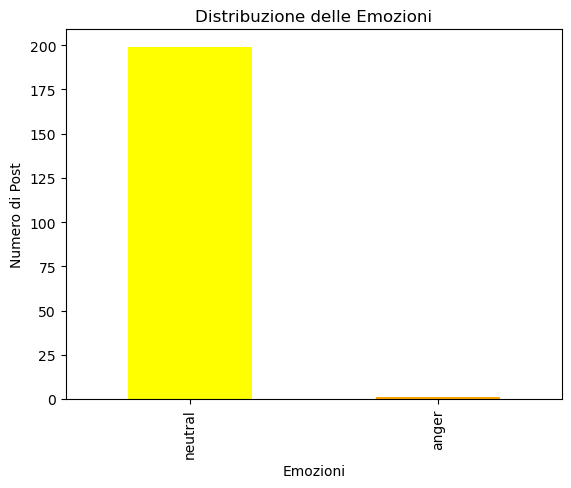

Risultati salvati in 'climate_change_sentiment_emotions_reddit.csv'


In [4]:
# Importazione delle librerie necessarie
import praw
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

nltk.download('vader_lexicon')

# Carica file env
load_dotenv(dotenv_path="reddit.env")

# Impostazioni API di Reddit (da configurare con le proprie credenziali)
CLIENT_ID = os.getenv("client_id")
CLIENT_SECRET = os.getenv("client_secret")
USER_AGENT = os.getenv("user_agent")

# Autenticazione con l'API di Reddit
def authenticate_reddit():
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT
    )
    return reddit

# Funzione per pulire il testo dei post
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Rimuove i link
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Rimuove caratteri speciali
    text = text.lower()  # Converte in minuscolo
    return text

# Funzione per analizzare il sentiment di un testo
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Funzione per rilevare emozioni specifiche utilizzando SentimentIntensityAnalyzer
def detect_emotion(text):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    if scores['neg'] > 0.5:
        return 'anger'
    elif 'fear' in text or scores['neg'] > 0.3 and scores['neu'] < 0.5:
        return 'fear'
    elif scores['pos'] > 0.5:
        return 'joy'
    elif scores['neg'] > 0.3 and 'sad' in text:
        return 'sadness'
    elif 'ecoanxiety' in text or 'climate anxiety' in text:
        return 'ecoanxiety'
    else:
        return 'neutral'

# Funzione per raccogliere i post basati su una parola chiave
def fetch_reddit_posts(reddit, subreddit_name, query, limit=10000):
    subreddit = reddit.subreddit(subreddit_name)
    posts = subreddit.search(query, limit=limit)
    post_data = []
    for post in posts:
        cleaned_text = clean_text(post.title + ' ' + post.selftext)
        sentiment = analyze_sentiment(cleaned_text)
        emotion = detect_emotion(cleaned_text)
        post_data.append({'title': post.title, 'text': cleaned_text, 'sentiment': sentiment, 'emotion': emotion})
    return pd.DataFrame(post_data)

# Funzione per visualizzare i risultati del sentiment
def plot_sentiment(df):
    sentiment_counts = df['sentiment'].value_counts()
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title('Distribuzione del Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Numero di Post')
    plt.show()

# Funzione per visualizzare i risultati delle emozioni
def plot_emotions(df):
    emotion_counts = df['emotion'].value_counts()
    emotion_counts.plot(kind='bar', color=['yellow', 'orange', 'gray', 'purple', 'cyan', 'black'])
    plt.title('Distribuzione delle Emozioni')
    plt.xlabel('Emozioni')
    plt.ylabel('Numero di Post')
    plt.show()

# Esecuzione principale
if __name__ == "__main__":
    reddit = authenticate_reddit()
    subreddit_name = "climate"
    query = "climate change"
    post_limit = 200

    print("Raccolta dei post da Reddit in corso...")
    posts_df = fetch_reddit_posts(reddit, subreddit_name, query, post_limit)
    print(posts_df.head())

    print("Visualizzazione del sentiment...")
    plot_sentiment(posts_df)

    print("Visualizzazione delle emozioni...")
    plot_emotions(posts_df)

    # Salvataggio dei risultati
    posts_df.to_csv('climate_change_sentiment_emotions_reddit.csv', index=False)
    print("Risultati salvati in 'climate_change_sentiment_emotions_reddit.csv'")
